In [1]:
# !git clone https://github.com/CompVis/taming-transformers

In [3]:
# !mkdir -p logs/vqgan_imagenet_f16_1024/checkpoints
# !mkdir -p logs/vqgan_imagenet_f16_1024/configs
# !wget 'https://heibox.uni-heidelberg.de/f/140747ba53464f49b476/?dl=1' -O 'logs/vqgan_imagenet_f16_1024/checkpoints/last.ckpt' 
# !wget 'https://heibox.uni-heidelberg.de/f/6ecf2af6c658432c8298/?dl=1' -O 'logs/vqgan_imagenet_f16_1024/configs/model.yaml' 

In [ ]:
%%capture
%pip install omegaconf>=2.0.0 pytorch-lightning>=1.0.8 einops>=0.3.0

In [1]:
cd taming-transformers

/workspace/taming-transformers


/opt/conda/lib/python3.10/site-packages/IPython/core/magics/osm.py:417: UserWarning: using dhist requires you to install the `pickleshare` library.
  self.shell.db['dhist'] = compress_dhist(dhist)[-100:]


In [2]:
import sys
sys.path.append(".")

# also disable grad to save memory
import torch
torch.set_grad_enabled(False)

DEVICE = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [3]:
import yaml
import torch
from omegaconf import OmegaConf
from taming.models.vqgan import VQModel, GumbelVQ

def load_config(config_path, display=False):
  config = OmegaConf.load(config_path)
  if display:
    print(yaml.dump(OmegaConf.to_container(config)))
  return config

def load_vqgan(config, ckpt_path=None, is_gumbel=False):
  if is_gumbel:
    model = GumbelVQ(**config.model.params)
  else:
    model = VQModel(**config.model.params)
  if ckpt_path is not None:
    sd = torch.load(ckpt_path, map_location="cpu")["state_dict"]
    missing, unexpected = model.load_state_dict(sd, strict=False)
  return model.eval()

def preprocess_vqgan(x):
  x = 2.*x - 1.
  return x

def custom_to_pil(x):
  x = x.detach().cpu()
  x = torch.clamp(x, -1., 1.)
  x = (x + 1.)/2.
  x = x.permute(1,2,0).numpy()
  x = (255*x).astype(np.uint8)
  x = Image.fromarray(x)
  if not x.mode == "RGB":
    x = x.convert("RGB")
  return x

def reconstruct_with_vqgan(x, model):
  # could also use model(x) for reconstruction but use explicit encoding and decoding here
  z, _, [_, _, indices] = model.encode(x)
  print(f"VQGAN --- {model.__class__.__name__}: latent shape: {z.shape[2:]}")
  xrec = model.decode(z)
  return xrec

In [4]:
config1024 = load_config("logs/vqgan_imagenet_f16_1024/configs/model.yaml", display=False)
model1024 = load_vqgan(config1024, ckpt_path="logs/vqgan_imagenet_f16_1024/checkpoints/last.ckpt").to(DEVICE)

Working with z of shape (1, 256, 16, 16) = 65536 dimensions.


/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


loaded pretrained LPIPS loss from taming/modules/autoencoder/lpips/vgg.pth
VQLPIPSWithDiscriminator running with hinge loss.


In [5]:
# Libraries
import math
import time
import torch
from tqdm import tqdm
import torch.optim as optim
import matplotlib.pyplot as plt
from dataclasses import dataclass
from torch.utils.data import DataLoader
from datasets import load_dataset, concatenate_datasets
from PIL import Image
#Otherwise, the tokenizer will through a warning
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
from safetensors.torch import load_model, save_model

import json
import os
import tempfile
from dataclasses import asdict
from typing import Optional



os.environ["TOKENIZERS_PARALLELISM"] = "false"

if torch.cuda.is_available():
    device = "cuda"
elif hasattr(torch.backends, "mps") and torch.backends.mps.is_available():
    device = "mps"
else:
    device = "cpu"
print(f"Using device: {device}")

torch.manual_seed(0)
torch.cuda.manual_seed_all(0)

# To reload the modules if you change something in the code
%reload_ext autoreload
%autoreload 2

Using device: cuda


In [6]:
import io
import os, sys
import requests
import PIL
from PIL import Image
from PIL import ImageDraw, ImageFont
import numpy as np

import torch
import torch.nn.functional as F
import torchvision.transforms as T
import torchvision.transforms.functional as TF

from datasets import load_dataset
import json
from tqdm.notebook import tqdm
from transformers import AutoTokenizer
import pickle

# from dall_e          import map_pixels, unmap_pixels, load_model
# from IPython.display import display, display_markdown

# font = ImageFont.truetype("/usr/share/fonts/truetype/liberation/LiberationSans-BoldItalic.ttf", 22)

def download_image(url):
    resp = requests.get(url)
    resp.raise_for_status()
    return PIL.Image.open(io.BytesIO(resp.content))


def preprocess(img, target_image_size=256):
    s = min(img.size)
    
    if s < target_image_size:
        raise ValueError(f'min dim for image {s} < {target_image_size}')
        
    r = target_image_size / s
    s = (round(r * img.size[1]), round(r * img.size[0]))
    img = TF.resize(img, s, interpolation=PIL.Image.LANCZOS)
    img = TF.center_crop(img, output_size=2 * [target_image_size])
    img = torch.unsqueeze(T.ToTensor()(img), 0)

    return img



def reconstruction_pipeline(url, size=256):
  x_vqgan = preprocess(download_image(url), target_image_size=size)
  x_vqgan = x_vqgan.to(DEVICE)
  
  print(f"input is of size: {x_vqgan.shape}")
  x2 = reconstruct_with_vqgan(preprocess_vqgan(x_vqgan), model1024)
  img = custom_to_pil(x2[0])
    
  # img = stack_reconstructions(custom_to_pil(preprocess_vqgan(x_vqgan[0])), x3, 
  #                             custom_to_pil(x0[0]), custom_to_pil(x1[0]), 
  #                             custom_to_pil(x2[0]), titles=titles)
  return img

input is of size: torch.Size([1, 3, 256, 256])
VQGAN --- VQModel: latent shape: torch.Size([16, 16])


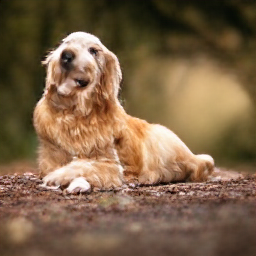

In [10]:
reconstruction_pipeline("https://pettownsendvet.com/wp-content/uploads/2023/01/iStock-1052880600-2048x1365.jpg")

In [12]:
x_vqgan = preprocess(download_image("https://pettownsendvet.com/wp-content/uploads/2023/01/iStock-1052880600-2048x1365.jpg"), 
                     target_image_size=256)
x_vqgan = x_vqgan.to(DEVICE)
x2 = reconstruct_with_vqgan(preprocess_vqgan(x_vqgan), model1024)

VQGAN --- VQModel: latent shape: torch.Size([16, 16])


In [17]:
x_vqgan = x_vqgan.to(DEVICE)
z, _, [_, _, indices] = model1024.encode(x_vqgan)

In [18]:
z.shape

torch.Size([1, 256, 16, 16])

In [21]:
indices.detach().cpu().numpy()

array([ 548,  287,  695,  692,  553,  171,  339,   40,  548,  916,  607,
        365,  593,  692,    4,  869,  969,  200,  460,  828,  376,  918,
        810,  577,  247,  705,  688,  333,  150,  976,  705,  925,  610,
        810,   83,  333,  112,  112,  192,  245,  600,  514,  887,  514,
        269,  706,  800,  365,  610,  695,  928,   13,  545,  479,  505,
        215,   80,  941,  148,  489,  865,  339,  541,  805,  969,  528,
        657,  436,  969,  758,  517,  669,  745,  808,  759,  808,  200,
        695,  109,  675,  294,  607,  494,  787,  237,  230,  787,  464,
        301,   20,  119,  107,  219,  136,  800,  269,  810,  906,  668,
         56,  925,  669,  494,  816,  358,  678,  695,  117,  800,  658,
        219,  389,  301,  868,  304,  611,  575,  256,  941,  219,  872,
        125,  109,   80,  682,  878,  308,  514,  375,  247,  468,  186,
        550,  773,   13,  120,  464,  580,  591,  849,  537,  537,  692,
        607,  911,  220,  669,  636,  120,  751,  7

#### сам датасет достаточно большой поэтому я скачиваю только 5000 примеров

In [24]:
# d = load_dataset("timbrooks/instructpix2pix-clip-filtered", split="train", streaming=True)

In [19]:
# !mkdir ../data/
# !mkdir ../data/images
# !mkdir ../data/prompts

In [25]:
# for i, e in tqdm(enumerate(d), ):
#     if i > 5000:
#         break
#     e['original_image'].save(f"../data/images/{i}_original.png")
#     e['edited_image'].save(f"../data/images/{i}_edited.png")
#     data = {"original_prompt": e["original_prompt"], "edit_prompt": e["edit_prompt"]}
#     json.dump(data, open(f'../data/prompts/{i}_prompt.json', 'w'))

#### еще я в первом прогоне предобрабатываю все vqgan моделью, чтобы потом она не использовалась при обучении

In [7]:
from torch.utils.data import Dataset


class VQGAN_Dataset(Dataset):  # Visual Question Answering Dataset
    def __init__(self, dataset_path, tokenizer, image_tokenizer, start=None, end=None, cached=False):
        self.cached = cached
        self.dataset_path = dataset_path
        if not cached:
            self.tokenizer = tokenizer
            self.image_tokenizer = image_tokenizer
            self.dataset = [file.split('_')[0] for file in os.listdir(dataset_path + "/prompts") if file.endswith('json')][start:end]
        else:
            self.dataset = [file.split('_')[0] for file in os.listdir(dataset_path + "/pickles") if file.endswith('pkl')][start:end]

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
        item = self.dataset[idx]
        if not self.cached:
            original_image = Image.open(f"{self.dataset_path}/images/{item}_original.png")
            edited_image = Image.open(f"{self.dataset_path}/images/{item}_edited.png")
            prompts = json.load(open(f"{self.dataset_path}/prompts/{item}_prompt.json"))
            description = prompts['original_prompt']
            prompt = prompts['edit_prompt']
    
            original_image = preprocess(original_image, target_image_size=256)
            edited_image = preprocess(edited_image, target_image_size=256)
            
    
            formatted_text = f"Original image description: {description}; Prompt: {prompt}; Answer:"
    
            original_image = original_image.to(DEVICE)
            edited_image = edited_image.to(DEVICE)
    
            z, _, [_, _, original_indices] = self.image_tokenizer.encode(original_image)
            z, _, [_, _, edited_indices] = self.image_tokenizer.encode(edited_image)
    
            return {
                "original_image": original_indices.detach().cpu().numpy(),
                "edited_image": edited_indices.detach().cpu().numpy(),
                "text_data": formatted_text,
            }
        else:
            return pickle.load(open(f"{self.dataset_path}/pickles/{item}_.pkl", 'rb'))

In [8]:

tokenizer = AutoTokenizer.from_pretrained("HuggingFaceTB/cosmo2-tokenizer", use_fast=True)
tokenizer.pad_token = tokenizer.eos_token

In [204]:
dataset = VQGAN_Dataset("../data", tokenizer, model1024)

In [26]:
# !mkdir ../data/pickles

In [11]:
# for i, example in tqdm(enumerate(dataset)):
    # pickle.dump(example, open(f'../data/pickles/{i}_.pkl', 'wb'))

In [12]:
# после первого прогона можно загружать cashed вариант
# модель и токенизатор передавать уже даже не нужно
dataset = VQGAN_Dataset("../data", tokenizer, None, cached=True)

In [14]:
dataset[0]

{'original_image': array([ 464,  489,  729,  794,  184,  878,  276,  977,  295,  437,  210,
          12,  656,  175,  712,  184,  845,   40,  471,  433,  816,  712,
          61,   12,  467,  932,   56,  751,  519,  541,  609,  892, 1006,
         373,  583,  887,  610,  107,  316,  932,  758,   40,   72,  283,
         358,  918,   80,  406,  469,  638,  707,  460,  323,  908,  371,
         707,  193,  519,  720,  494,  308,  682,  354,  192,  176,  669,
         800,  175,  358,  256,  134,   56,  304,  519, 1012,  479,  257,
         226,  389,  892,  548,  254,  769,  471,  916,  705,   31,  193,
         682,  578,  210,  969,  334,  869,  803,  915,  932,  176,   12,
         961,  849,  156,  125,  560,  783,  887,   82,  759,  435,  587,
         258,  184,  184,  662,  868,  575,  633,  134,  821,  680,  306,
          49,  719,  932,  315,  426,  503,  742,  550,  297,  751,  759,
         308,  163,  830,   49,  587,  805,  868,  789,  519,  148,   61,
         400,  129, 

In [9]:
import torch

def pad_lists(lists, target_length, pad_value=0, side='right'):
    result = []
    for sublist in lists:
        if len(sublist) > target_length:
            if side == 'right':
                trimmed = sublist[:target_length]
            else:
                trimmed = sublist[-target_length:]
        else:
            pad_size = target_length - len(sublist)
            padding = [pad_value] * pad_size
            trimmed = sublist + padding if side == 'right' else padding + sublist
        result.append(trimmed)
    return result


class VQ_Collator(object):  # Visual Question Answering Collator
    def __init__(self, tokenizer, max_length):
        self.tokenizer = tokenizer
        self.max_length = max_length
    
    def __call__(self, batch):

        texts = [b['text_data'] for b in batch]
        tokenized = self.tokenizer.batch_encode_plus(texts, padding=False, truncation=False)
        
        or_tokens = [(b['original_image'] + tokenizer.vocab_size).tolist() for b in batch]
        ed_tokens = [(b['edited_image'] + tokenizer.vocab_size).tolist() for b in batch]
        
        input_tokens = [a+b+c for a, b, c in zip(or_tokens, tokenized['input_ids'], ed_tokens)]
        padded_input_tokens = torch.LongTensor(pad_lists(input_tokens, self.max_length, pad_value=self.tokenizer.pad_token_id, side='left'))
        lengths = [len(i) for i in ed_tokens]

        labels = padded_input_tokens.clone()
        labels[:, :-1] = padded_input_tokens[:, 1:].clone()
        labels[:, -1] = tokenizer.eos_token_id

        for i in range(len(lengths)):
            prompt_end = lengths[i] - 1 
            labels[i, :prompt_end] = -100

        attention_masks = (padded_input_tokens!=self.tokenizer.pad_token_id).long()


        return {
            "input_ids": padded_input_tokens,
            "attention_mask": attention_masks,
            "labels": labels
        }

In [10]:


# https://github.com/huggingface/transformers/blob/main/src/transformers/models/llama/modeling_llama.py#L69
class RMSNorm(nn.Module):
    def __init__(self, cfg):
        super().__init__()
        self.weight = nn.Parameter(torch.ones(cfg.lm_hidden_dim))
        self.eps = cfg.lm_rms_eps

    def forward(self, x):
        irms = torch.rsqrt(torch.mean(x ** 2, dim=-1, keepdim=True) + self.eps) # inverse of RMS
        x = x * irms * self.weight

        return x

# Multiple derivates of Rotary Embeddings by now, this is a basic one with linear scaling to context length
# e.g. https://github.com/huggingface/smollm/blob/main/vision/m4/models/vllama3/modeling_vllama3.py#L190
class RotaryEmbedding(nn.Module):
    def __init__(self, cfg):
        super().__init__()
        assert cfg.lm_hidden_dim % cfg.lm_n_heads == 0, "Hidden dimension must be divisible by number of heads"
        
        self.dim = cfg.lm_hidden_dim // cfg.lm_n_heads # dim of each head
        self.base = cfg.lm_re_base
        self.max_seq_len = cfg.lm_max_position_embeddings
        # Standard RoPE implementation - create frequencies for each dimension
        # freq_i = 1 / (base^(2i/dim)) where i is the dimension index
        inv_freq = 1.0 / (self.base ** (torch.arange(0, self.dim, 2).float() / self.dim))
        self.register_buffer("inv_freq", inv_freq)
        self.original_max_seq_len = cfg.lm_max_position_embeddings
        self.attention_scaling = cfg.lm_attn_scaling

    # @torch.no_grad()
    def forward(self, position_ids):
        batch_size, seq_len = position_ids.shape
        # Dynamic scaling for longer sequences
        max_seq = position_ids.max() + 1
        if max_seq > self.original_max_seq_len:
            scale = max_seq / self.original_max_seq_len
            inv_freq = self.inv_freq / scale
        else:
            inv_freq = self.inv_freq
            
        # Compute theta = position * frequency
        # Flatten position_ids for batch processing
        flat_position_ids = position_ids.reshape(-1).float()
        
        # Element-wise outer product: [seq_len] x [dim/2] => [seq_len, dim/2]
        freqs = flat_position_ids.unsqueeze(-1) * inv_freq.unsqueeze(0)
        
        # Reshape to include batch dimension
        freqs = freqs.reshape(batch_size, seq_len, -1)
        
        # Now create interleaved pattern
        emb = torch.cat([freqs, freqs], dim=-1)
        
        # Compute cos and sin
        cos = torch.cos(emb) * self.attention_scaling
        sin = torch.sin(emb) * self.attention_scaling
        
        return cos, sin

# Rotates half the hidden dims of the input by swapping and negating dimensions.
def rotate_half(x):
    x1, x2 = x.chunk(2, dim=-1)
    return torch.cat((-x2, x1), dim=-1)

# Apply rotary position embeddings to queries and keys.
def apply_rotary_pos_embd(q, k, cos, sin, unsqueeze_dim=1):
    # We need to make sure cos and sin can be properly broadcast
    # to the shape of q and k by adding the heads dimension
    cos = cos.unsqueeze(unsqueeze_dim)  # [batch_size, 1, seq_len, head_dim]
    sin = sin.unsqueeze(unsqueeze_dim)  # [batch_size, 1, seq_len, head_dim]
    
    # Apply complex multiplication:
    # (q * cos) + (rotate_half(q) * sin)
    q_embed = (q * cos) + (rotate_half(q) * sin)
    k_embed = (k * cos) + (rotate_half(k) * sin)
    
    return q_embed, k_embed

# https://github.com/huggingface/transformers/blob/main/src/transformers/models/llama/modeling_llama.py#L214
# https://github.com/huggingface/smollm/blob/main/vision/m4/models/vllama3/modeling_vllama3.py#L382
class LanguageModelGroupedQueryAttention(nn.Module):
    def __init__(self, cfg):
        super().__init__()

        self.n_heads = cfg.lm_n_heads
        self.n_kv_heads = cfg.lm_n_kv_heads
        self.embd_dim = cfg.lm_hidden_dim
        self.dropout = cfg.lm_dropout

        assert self.n_heads % self.n_kv_heads == 0, "n_heads must be divisible by n_kv_heads"
        assert self.embd_dim % self.n_heads == 0, "embd_dim must be divisible by num_heads"

        self.n_kv_groups = self.n_heads // self.n_kv_heads
        self.head_dim = self.embd_dim // self.n_heads

        self.q_proj = nn.Linear(self.embd_dim, self.embd_dim, bias=False)
        self.k_proj = nn.Linear(self.embd_dim, self.head_dim * self.n_kv_heads, bias=False)
        self.v_proj = nn.Linear(self.embd_dim, self.head_dim * self.n_kv_heads, bias=False)
        self.out_proj = nn.Linear(self.embd_dim, self.embd_dim, bias=False)

        self.attn_dropout = nn.Dropout(self.dropout)
        self.resid_dropout = nn.Dropout(self.dropout)

        # Use scaled dot product attention if available
        # self.sdpa = hasattr(torch.nn.functional, 'scaled_dot_product_attention')
        self.sdpa = False
        # if not self.sdpa:
        #     print("Warning: scaled dot product attention not available, using standard attention in LM.")

    def forward(self, x, cos, sin, attention_mask=None):
        B, T, C = x.size()

        q = self.q_proj(x).view(B, T, self.n_heads, self.head_dim).transpose(1, 2)  # (B, n_heads, T, head_dim)
        k = self.k_proj(x).view(B, T, self.n_kv_heads, self.head_dim).transpose(1, 2)  # (B, n_kv_heads, T, head_dim)
        v = self.v_proj(x).view(B, T, self.n_kv_heads, self.head_dim).transpose(1, 2)  # (B, n_kv_heads, T, head_dim)
        
        # Use precomputed positional embeddings
        q, k = apply_rotary_pos_embd(q, k, cos, sin)

        k = k.repeat_interleave(self.n_kv_groups, dim=1)
        v = v.repeat_interleave(self.n_kv_groups, dim=1)

        # Process attention mask if provided
        if attention_mask is not None:
            # Create a 4D attention mask [batch_size, 1, 1, seq_length], In this format, 1 = attend, 0 = mask
            attention_mask = attention_mask.unsqueeze(1).unsqueeze(2)  # [B, 1, 1, T]
            padding_mask = (attention_mask == 0).transpose(-1, -2) # Use this for the manual path
            # Convert to attention mask where 0 keeps values and -inf masks
            attention_mask = (1.0 - attention_mask) * torch.finfo(q.dtype).min

        if self.sdpa:
            y = torch.nn.functional.scaled_dot_product_attention(
                q, k, v,
                attn_mask=attention_mask,
                dropout_p=self.dropout if self.training else 0.0,
                is_causal=True # LM attention is causal (masked)
            )
        else:
            attn = torch.matmul(q, k.transpose(2, 3)) / math.sqrt(self.head_dim)
            causal_mask = torch.tril(torch.ones(T, T, device=x.device)).view(1, 1, T, T)
            attn = attn.masked_fill(causal_mask == 0, float('-inf'))
            if attention_mask is not None:
                attn = attn + attention_mask 

            attn = F.softmax(attn, dim=-1)
            attn = self.attn_dropout(attn)
            y = attn @ v
            
            if attention_mask is not None:
                y = y.masked_fill(padding_mask, 0.0) # Zero out the padded positions in the output

        y = y.transpose(1, 2).contiguous().view(B, T, C)  
        y = self.out_proj(y)
        y = self.resid_dropout(y)

        return y

# https://github.com/huggingface/transformers/blob/main/src/transformers/models/llama/modeling_llama.py#L160
class LanguageModelMLP(nn.Module):
    def __init__(self, cfg):
        super().__init__()
        self.embd_dim = cfg.lm_hidden_dim
        self.inter_dim = cfg.lm_inter_dim

        self.activation_fn = F.silu
        self.gate_proj = nn.Linear(self.embd_dim, self.inter_dim, bias=False)
        self.up_proj = nn.Linear(self.embd_dim, self.inter_dim, bias=False)
        self.down_proj = nn.Linear(self.inter_dim, self.embd_dim, bias=False)

    def forward(self, x):
        gate = self.activation_fn(self.gate_proj(x))
        x = self.up_proj(x)
        x = self.down_proj(gate * x)

        return x

# https://github.com/meta-llama/llama3/blob/main/llama/model.py#L222
class LanguageModelBlock(nn.Module):
    def __init__(self, cfg):
        super().__init__()
        self.mlp = LanguageModelMLP(cfg)
        self.attn = LanguageModelGroupedQueryAttention(cfg)
        self.norm1 = RMSNorm(cfg) # Input Norm
        self.norm2 = RMSNorm(cfg) # Post Attention Norm
    
    def forward(self, x, cos, sin, attention_mask=None):
        res = x
        x = self.norm1(x)
        x = self.attn(x, cos, sin, attention_mask)
        x = res + x

        res = x
        x = self.norm2(x)
        x = self.mlp(x)
        x = res + x

        return x

# https://github.com/meta-llama/llama3/blob/main/llama/model.py#L251
class LanguageModel(nn.Module):
    def __init__(self, cfg):
        super().__init__()
        self.cfg = cfg
        self.lm_use_tokens = cfg.lm_use_tokens
        self.lm_tie_weights = cfg.lm_tie_weights

        self.token_embedding = nn.Embedding(cfg.lm_vocab_size, cfg.lm_hidden_dim)
        self.rotary_embd = RotaryEmbedding(cfg)
        self.blocks = nn.ModuleList([
            LanguageModelBlock(cfg) for _ in range(cfg.lm_n_blocks)
        ])
        self.norm = RMSNorm(cfg) # Final Norm
        self.head = nn.Linear(cfg.lm_hidden_dim, cfg.lm_vocab_size, bias=False)
        if self.lm_tie_weights:
            self.head.weight = self.token_embedding.weight

        self.apply(self._init_weights)

    def _init_weights(self, module):
        if isinstance(module, nn.Linear):
            torch.nn.init.normal_(module.weight, mean=0.0, std=0.02)
            if module.bias is not None:
                torch.nn.init.zeros_(module.bias)
        elif isinstance(module, nn.Embedding):
            torch.nn.init.normal_(module.weight, mean=0.0, std=0.02)
        elif isinstance(module, RMSNorm):
            module.weight.data.fill_(1.0)

    def forward(self, x, attention_mask=None):

        if self.lm_use_tokens:
            x = self.token_embedding(x) # Only embed the inputs when using tokens

        B , T, _ = x.size()
        
        # Note: You could also cache these input embeddings if you want to avoid recomputing them
        position_ids = torch.arange(T, device=x.device).unsqueeze(0).expand(B, -1) # Create position ids [0, 1, 2, ..., seq_len-1]
        cos, sin = self.rotary_embd(position_ids) # Get rotary position embeddings

        for block in self.blocks:
            x = block(x, cos, sin, attention_mask)
        x = self.norm(x)

        if self.lm_use_tokens:
            x = self.head(x) # Compute logits if we are using tokens, otherwise stay in the embedding space


        return x

    @torch.no_grad()
    def generate(self, inputs, max_new_tokens=20):
        # Add batch dimension if needed
        if inputs.dim() == 1:
            inputs = inputs.unsqueeze(0)
            
        generated = inputs.clone()
        
        for _ in range(max_new_tokens):
            # Forward pass through the model
            outputs = self.forward(generated)
            last_output = outputs[:, -1, :]

            if self.lm_use_tokens:
                # Now the model outputs logits
                next_token = torch.argmax(last_output, dim=-1, keepdim=True)
                generated = torch.cat((generated, next_token), dim=-1)
            else:
                # Now the model outputs embeddings
                next_token_embedding = last_output.unsqueeze(1)  # Shape: [batch_size, 1, hidden_dim]
                generated = torch.cat((generated, next_token_embedding), dim=1)
            
            #Note: You could enable the generation to break earlier than max_new_tokens when it detects a eos token, but this does not work in batched generation (output tensors need to have the same size)
    
        return generated

    # Load the model from a pretrained HuggingFace model (we don't want to have to train the Language Backbone from scratch)
    @classmethod
    def from_pretrained(cls, cfg):
        from transformers import AutoConfig
        from huggingface_hub import hf_hub_download
        import safetensors
        import torch.nn.init as init
                
        # Load the HuggingFace config
        hf_config = AutoConfig.from_pretrained(cfg.lm_model_type)
        
        # Store original HF vocab size before we modify it
        original_vocab_size = hf_config.vocab_size
        # print(f"Original vocabulary size from pretrained model: {original_vocab_size}")
        
        # Configure model parameters from HF config
        cfg.lm_hidden_dim = hf_config.hidden_size
        cfg.lm_inter_dim = hf_config.intermediate_size
        cfg.lm_rms_eps = hf_config.rms_norm_eps
        cfg.lm_re_base = hf_config.rope_theta
        cfg.lm_max_position_embeddings = hf_config.max_position_embeddings
        # We're keeping our own vocab size in cfg, but checking it's larger than original
        if hasattr(cfg, 'lm_vocab_size'):
            if cfg.lm_vocab_size < original_vocab_size:
                raise ValueError(f"Config vocab size ({cfg.lm_vocab_size}) is smaller than pretrained model vocab size ({original_vocab_size})")
            # print(f"Using vocabulary size: {cfg.lm_vocab_size}")
        else:
            # If not specified, use the original
            cfg.lm_vocab_size = original_vocab_size
            # print(f"Using original vocabulary size: {cfg.lm_vocab_size}")
        
        cfg.lm_n_heads = hf_config.num_attention_heads
        cfg.lm_n_kv_heads = hf_config.num_key_value_heads
        cfg.lm_dropout = hf_config.attention_dropout
        cfg.lm_n_blocks = hf_config.num_hidden_layers
        
        # Create our model with potentially larger vocabulary
        model = cls(cfg)
        safetensors_file = hf_hub_download(repo_id=cfg.lm_model_type, filename="model.safetensors")
        
        sd = model.state_dict()
        
        mapping = {
            'model.embed_tokens.weight': 'token_embedding.weight',
            'model.norm.weight': 'norm.weight'
        }
        
        for i in range(cfg.lm_n_blocks):
            layer_prefix = f'model.layers.{i}.'
            block_prefix = f'blocks.{i}.'
            
            mapping.update({
                f"{layer_prefix}self_attn.q_proj.weight": f"{block_prefix}attn.q_proj.weight",
                f"{layer_prefix}self_attn.k_proj.weight": f"{block_prefix}attn.k_proj.weight",
                f"{layer_prefix}self_attn.v_proj.weight": f"{block_prefix}attn.v_proj.weight",
                f"{layer_prefix}self_attn.o_proj.weight": f"{block_prefix}attn.out_proj.weight",
                f"{layer_prefix}mlp.gate_proj.weight": f"{block_prefix}mlp.gate_proj.weight",
                f"{layer_prefix}mlp.up_proj.weight": f"{block_prefix}mlp.up_proj.weight",
                f"{layer_prefix}mlp.down_proj.weight": f"{block_prefix}mlp.down_proj.weight",
                f"{layer_prefix}input_layernorm.weight": f"{block_prefix}norm1.weight",
                f"{layer_prefix}post_attention_layernorm.weight": f"{block_prefix}norm2.weight"
            })
        
        # Special handling for token embeddings with extended vocabulary
        has_extended_embeddings = False
        with safetensors.safe_open(filename=safetensors_file, framework="pt", device="cpu") as f:
            for hf_key, our_key in mapping.items():
                if hf_key in f.keys() and our_key in sd:
                    tensor = f.get_tensor(hf_key)
                    
                    # Special handling for token embeddings if vocab sizes differ
                    if hf_key == 'model.embed_tokens.weight' and tensor.shape[0] != sd[our_key].shape[0]:
                        has_extended_embeddings = True
                        print(f"Extending token embeddings from {tensor.shape} to {sd[our_key].shape}")
                        
                        # Copy existing embeddings to the beginning of our larger embedding matrix
                        sd[our_key][:tensor.shape[0]].copy_(tensor)
                        
                        # Initialize the new embeddings using the same approach as the original model
                        std = 0.02  # Common value, but you might want to adjust based on model
                        init.normal_(sd[our_key][tensor.shape[0]:], mean=0.0, std=std)
                        
                        print(f"Initialized {sd[our_key].shape[0] - tensor.shape[0]} new token embeddings")
                        sd['head.weight'].copy_(sd[our_key])  # Update the head weights as well
                    elif tensor.shape == sd[our_key].shape:
                        sd[our_key].copy_(tensor)
                    else:
                        print(f"Shape mismatch for {hf_key} -> {our_key}: {tensor.shape} vs {sd[our_key].shape}")
                else:
                    if hf_key not in f.keys():
                        print(f"Warning: Key {hf_key} not found in safetensors file")
                    if our_key not in sd:
                        print(f"Warning: Key {our_key} not found in model state dict")
        
        # Load the state dict
        model.load_state_dict(sd)
        
        # Handle output projection / language modeling head
        if has_extended_embeddings and hasattr(model, 'head') and 'head.weight' in sd:
            # If we have a separate output projection layer and extended the vocab
            # we should handle it similarly to the input embeddings
            with safetensors.safe_open(filename=safetensors_file, framework="pt", device="cpu") as f:
                if 'lm_head.weight' in f.keys():
                    lm_head = f.get_tensor('lm_head.weight')
                    if lm_head.shape[0] != sd['head.weight'].shape[0]:
                        print(f"Extending LM head from {lm_head.shape} to {sd['head.weight'].shape}")
                        # Copy existing weights
                        sd['head.weight'][:lm_head.shape[0]].copy_(lm_head)
                        # Initialize new weights
                        std = 0.02
                        init.normal_(sd['head.weight'][lm_head.shape[0]:], mean=0.0, std=std)
                        # Load updated weights
                        model.load_state_dict(sd)
        
        # Handle weight tying (if needed)
        if cfg.lm_tie_weights and hasattr(model, 'head') and hasattr(model, 'token_embedding'):
            model.head.weight = model.token_embedding.weight
            # print("Tied token embedding and LM head weights")
        
        print(f"Successfully loaded {cfg.lm_model_type} weights from safetensors. Model has {sum(p.numel() for p in model.parameters()):,} parameters.")
        return model


In [38]:

class VisionLanguageModel(nn.Module):
    def __init__(self, cfg, load_backbone=True):
        super().__init__()
        self.cfg = cfg
        if load_backbone:
            self.decoder = LanguageModel.from_pretrained(cfg)
        else:
            self.decoder = LanguageModel(cfg)
        self.load_backbone = load_backbone

    def forward(self, input_ids, attention_mask=None, targets=None):

        logits = self.decoder(input_ids, attention_mask) # Not logits yet, but easier to return like this

        loss = None
        if targets is not None:
            loss = F.cross_entropy(logits.reshape(-1, logits.size(-1)), targets.reshape(-1), ignore_index=-100)

        return logits, loss

    @torch.no_grad()
    def generate(self, input_ids, attention_mask=None, max_new_tokens=5, top_k=50, top_p=0.9, temperature=0.5, greedy=False):

        # Embed initial tokens
        # token_embd = self.decoder.token_embedding(input_ids)
        
        
        batch_size = input_ids.size(0)
        
        # Generate from combined embeddings using the decoder
        # We need to use the decoder's forward function and not its generate method
        # because we want to keep track of the image prefix
        outputs = input_ids
        generated_tokens = torch.zeros((batch_size, max_new_tokens), device=input_ids.device, dtype=input_ids.dtype)
        
        #Note: Here you could implement improvements like e.g. KV caching
        for i in range(max_new_tokens):
            model_out = self.decoder(outputs, attention_mask)
            
            # Get predictions for the last token only (normally this is the embedding, not the logits)
            last_token_logits = model_out[:, -1, :]
            
            # Apply head to get logits (if model is in embedding mode)
            if not self.decoder.lm_use_tokens:
                last_token_logits = self.decoder.head(last_token_logits)
            if greedy:
                next_token = torch.argmax(last_token_logits, dim=-1, keepdim=True)
            else:
                filtered_logits = top_k_top_p_filtering(last_token_logits, top_k=top_k, top_p=top_p)
                probs = torch.softmax(filtered_logits/temperature, dim=-1)
                next_token = torch.multinomial(probs, num_samples=1)
            if next_token.item() == 0:
                break
                
            generated_tokens[:, i] = next_token.squeeze(-1)
            
            # Convert to embedding and append
            # next_embd = self.decoder.token_embedding(next_token)
            outputs = torch.cat((outputs, next_token), dim=1)

            if attention_mask is not None:
                attention_mask = torch.cat((attention_mask, torch.ones((batch_size, 1), device=attention_mask.device)), dim=1)
        
        return generated_tokens

    @classmethod
    def from_pretrained(
        cls, repo_id_or_path: str, *, revision: Optional[str] = None
    ) -> "VisionLanguageModel":
        """
        Load a VisionLanguageModel from a local directory or a repo on the Hugging Face Hub.

        Args:
            repo_id_or_path (str): The path to the local directory or the Hugging Face Hub repo ID.

        Returns:
            VisionLanguageModel: The loaded model.
        """
        # If local folder exists => load from there
        if os.path.exists(repo_id_or_path):
            config_path = os.path.join(repo_id_or_path, "config.json")
            weights_path = os.path.join(repo_id_or_path, "model.safetensors")

            if not os.path.exists(config_path):
                raise ValueError(
                    f"Config file not found at {config_path}. Please provide a valid path."
                )
            if not os.path.exists(weights_path):
                raise ValueError(
                    f"Weights file not found at {weights_path}. Please provide a valid path."
                )
        # Otherwise, assume it's a Hugging Face Hub repo
        else:
            from huggingface_hub import hf_hub_download

            config_path = hf_hub_download(
                repo_id=repo_id_or_path, filename="config.json", revision=revision
            )
            weights_path = hf_hub_download(
                repo_id=repo_id_or_path, filename="model.safetensors", revision=revision
            )

        # Load config
        with open(config_path, "r") as f:
            cfg = VLMConfig(**json.load(f))

        # Initialize model without loading the backbone
        model = cls(cfg, load_backbone=False)

        # Load safetensors weights
        load_model(model, weights_path)

        # Done!
        return model

    def save_pretrained(self, save_directory: str) -> None:
        """
        Save the model and configuration to a directory.

        Args:
            save_directory (str): The directory to save the model and config.
        """
        # Create directory if it doesn't exist
        os.makedirs(save_directory, exist_ok=True)

        # Save config
        with open(os.path.join(save_directory, "config.json"), "w") as f:
            f.write(json.dumps(asdict(self.cfg), indent=4))

        # Save weights as safetensors
        save_model(self, os.path.join(save_directory, "model.safetensors"))

In [12]:
def get_lr(it, max_lr, max_steps):
    min_lr = max_lr * 0.1
    warmup_steps = max_steps * 0.03
    # 1) linear warmup for warmup_iters steps
    if it < warmup_steps:
        return max_lr * (it+1) / warmup_steps
    # 2) if it > lr_decay_iters, return min learning rate
    if it > max_steps:
        return min_lr
    # 3) in between, use cosine decay down to min learning rate
    decay_ratio = (it - warmup_steps) / (max_steps - warmup_steps)
    assert 0 <= decay_ratio <= 1
    coeff = 0.5 * (1.0 + math.cos(math.pi * decay_ratio)) # coeff starts at 1 and goes to 0
    return min_lr + coeff * (max_lr - min_lr)


In [13]:


def get_dataloaders(tokenizer, vqgan_model):
    
    train_dataset = VQGAN_Dataset("../data", tokenizer, vqgan_model, 0, 3000, cached=True)
    val_dataset = VQGAN_Dataset("../data", tokenizer, vqgan_model, 3000, 3100, cached=True)
    test_dataset = VQGAN_Dataset("../data", tokenizer, vqgan_model, 3100, 3200, cached=True)
    
    # Create collators
    vq_collator = VQ_Collator(tokenizer, 550)
    
    
    # Create dataloaders
    train_loader = DataLoader(
        train_dataset,
        batch_size=4,
        shuffle=True,
        collate_fn=vq_collator,
        num_workers=10,
        pin_memory=True,
        drop_last=True,
        prefetch_factor=10,
    )
    
    val_loader = DataLoader(
        val_dataset,
        batch_size=4,
        shuffle=False,
        collate_fn=vq_collator,
        num_workers=4,
        pin_memory=True,
        drop_last=True,
        prefetch_factor=10,
    )
    
    test_loader = DataLoader(
        test_dataset,
        batch_size=4,
        shuffle=False,
        collate_fn=vq_collator,
        num_workers=4,
        pin_memory=True,
        drop_last=True,
        prefetch_factor=10,
    )

    return train_loader, test_loader

In [14]:

def train(train_cfg, vlm_cfg):
    
    tokenizer = AutoTokenizer.from_pretrained(vlm_cfg.lm_tokenizer, use_fast=True)
    tokenizer.pad_token = tokenizer.eos_token

    train_loader, val_loader = get_dataloaders(tokenizer, None)

    
    # Initialize model
    if train_cfg.resume_from_vlm_checkpoint:
        print("Resuming from checkpoint")
        model = VisionLanguageModel.from_pretrained(vlm_cfg.vlm_checkpoint_path)
    else:
        model = VisionLanguageModel(vlm_cfg)

    print(f"nanoVLM initialized with {sum(p.numel() for p in model.parameters()):,} parameters")
    print(f"Training summary: {len(train_loader.dataset)} samples, {len(train_loader)} batches/epoch, batch size {train_cfg.batch_size}")

    # Define optimizer groups
    param_groups = [{'params': model.parameters(), 'lr': train_cfg.lr_backbones}]
    optimizer = optim.AdamW(param_groups)

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)
    if train_cfg.compile:
        model = torch.compile(model)

    epoch_times = []
    batch_losses = []
    val_losses = []
    val_plot_steps = []
    best_accuracy = 0
    global_step = 0
    for epoch in range(train_cfg.epochs):
        epoch_start_time = time.time()
        model.train()
        total_train_loss = 0
        total_tokens_processed = 0

        for batch in tqdm(train_loader):
            batch_start_time = time.time()
            input_ids = batch["input_ids"].to(device)
            labels = batch["labels"].to(device)
            attention_mask = batch["attention_mask"].to(device)

            optimizer.zero_grad()

            # with torch.autocast(device_type='cuda', dtype=torch.float16): # Mixed precision training
            _, loss = model(input_ids, attention_mask=attention_mask, targets=labels)


            loss.backward()

            adj_lr_backbones = get_lr(global_step, train_cfg.lr_backbones, len(train_loader) * train_cfg.epochs)
            optimizer.param_groups[0]['lr'] = adj_lr_backbones

            optimizer.step()

            batch_loss = loss.item()
            total_train_loss += batch_loss
            batch_losses.append(batch_loss)

            num_tokens = torch.sum(attention_mask).item() # Sum of attention mask gives number of tokens
            # num_tokens += images.shape[0] * ((images.shape[2] / vlm_cfg.vit_patch_size) ** 2) / (vlm_cfg.mp_pixel_shuffle_factor ** 2) # Add image tokens = batch_size * (((img_size / patch_size) ** 2) / (pixel_shuffle_factor ** 2))
            total_tokens_processed += num_tokens

            batch_end_time = time.time()
            batch_duration = batch_end_time - batch_start_time
            tokens_per_second = num_tokens / batch_duration
            model.save_pretrained(save_directory=vlm_cfg.vlm_checkpoint_path)

            if global_step % 300 == 0:
                model.eval()
                torch.cuda.empty_cache()  # Clear GPU memory
                with torch.no_grad():
                    total_val_loss = 0
                    for batch in val_loader:
                        input_ids = batch["input_ids"].to(device)
                        labels = batch["labels"].to(device)
                        attention_mask = batch["attention_mask"].to(device)

                        # with torch.amp.autocast(device_type='cuda', dtype=torch.float16):
                        _, loss = model(input_ids, attention_mask=attention_mask, targets=labels)

                        total_val_loss += loss.item()
                    avg_val_loss = total_val_loss / len(val_loader)
                    val_losses.append(avg_val_loss)
                    val_plot_steps.append(global_step)
                epoch_accuracy = 0
                if train_cfg.eval_in_epochs:
                    epoch_accuracy = test_mmstar(model, tokenizer, test_loader, device)
                    if epoch_accuracy > best_accuracy:
                      best_accuracy = epoch_accuracy
                      model.save_pretrained(save_directory=vlm_cfg.vlm_checkpoint_path)
                    print(f"\nStep: {global_step}, Loss: {batch_loss:.4f}, Val Loss: {avg_val_loss:.4f}, Tokens/s: {tokens_per_second:.2f}, Accuracy: {epoch_accuracy:.4f}")
                model.train()

            global_step += 1

        avg_train_loss = total_train_loss / len(train_loader)

        epoch_end_time = time.time()
        epoch_duration = epoch_end_time - epoch_start_time
        epoch_times.append(epoch_duration)

        epoch_tokens_per_second = total_tokens_processed / epoch_duration

        print(f"Epoch {epoch+1}/{train_cfg.epochs} | Train Loss: {avg_train_loss:.4f} | Val Loss: {avg_val_loss:.4f} | Time: {epoch_duration:.2f}s | T/s: {epoch_tokens_per_second:.2f}")

    # Summary Statistics
    # if not train_cfg.eval_in_epochs:
      # model.save_pretrained(save_directory=vlm_cfg.vlm_checkpoint_path)
      # model.push_to_hub(hf_model_name)
    model.save_pretrained(save_directory=vlm_cfg.vlm_checkpoint_path)

    avg_epoch_time = sum(epoch_times) / len(epoch_times)
    total_training_time = sum(epoch_times)
    total_samples_processed = len(train_loader.dataset) * train_cfg.epochs
    avg_time_per_sample = total_training_time / total_samples_processed
    print(f"Average time per epoch: {avg_epoch_time:.2f}s")
    print(f"Average time per sample: {avg_time_per_sample:.4f}s")

    plt.plot(batch_losses, label='Train Loss')
    plt.plot(val_plot_steps, val_losses, label='Val Loss')
    plt.xlabel('Batch')
    plt.ylabel('Loss')
    plt.title('Loss Curve')
    plt.grid(True)
    plt.legend()
    plt.show()
    
    # With this code you can test the accuracy of the model on the MMStar dataset
    # But if you only train with few samples, the accuracy will be very low
    # print("Testing MMStar Accuracy:")
    # accuracy = test_mmstar(model, tokenizer, test_loader, device)
    # print(f"MMStar Accuracy: {accuracy:.4f}")

In [15]:
def top_k_top_p_filtering(logits, top_k=0, top_p=1.0, filter_value=-float('Inf')):
    """
    Apply top-k and/or nucleus (top-p) filtering to logits.
    """
    top_k = min(top_k, logits.size(-1))  # Safety

    if top_k > 0:
        # Remove all tokens with a probability less than the top-k tokens
        indices_to_remove = logits < torch.topk(logits, top_k)[0][..., -1, None]
        logits = logits.masked_fill(indices_to_remove, filter_value)

    if top_p < 1.0:
        sorted_logits, sorted_indices = torch.sort(logits, descending=True)
        cumulative_probs = torch.softmax(sorted_logits, dim=-1).cumsum(dim=-1)

        # Remove tokens with cumulative probability above top_p
        sorted_indices_to_remove = cumulative_probs > top_p

        # Always keep the first token
        sorted_indices_to_remove[..., 0] = False
        
        indices_to_remove = sorted_indices_to_remove.scatter(1, sorted_indices, sorted_indices_to_remove)
        logits = logits.masked_fill(indices_to_remove, filter_value)

    return logits

In [67]:
from dataclasses import dataclass
@dataclass
class VLMConfig:
    lm_hidden_dim: int = 576
    lm_inter_dim: int = 1536
    lm_rms_eps: float = 1e-5
    lm_re_base: int = 100000
    lm_max_position_embeddings: int = 8192
    lm_vocab_size: int = 49152 + 1024 # size of the image tokenizer
    lm_n_heads: int = 9
    lm_n_kv_heads: int = 3
    lm_dropout: float = 0.0
    lm_n_blocks: int = 30
    lm_attn_scaling: float = 1.0
    lm_use_tokens: bool = True # Decide if the LM expects tokens or embeddings as input (if using as a backbone for the VLM, set to False)
    lm_tie_weights: bool = True # Decide if you want to tie the LM Head weight to the token embedding weights
    lm_model_type: str = 'HuggingFaceTB/SmolLM2-135M'
    lm_tokenizer: str = 'HuggingFaceTB/cosmo2-tokenizer'
    lm_eos_token_id: int = 0

    vlm_load_backbone_weights: bool = True
    vlm_checkpoint_path: str = 'checkpoints/nanoVLM-222M_vqgan_pix2pix'


@dataclass
class TrainConfig:
    lr_mp: float = 1e-3
    lr_backbones: float = 5e-5
    compile: bool = False
    gradient_accumulation_steps: int = 1
    batch_size: int = 10
    epochs: int = 20
    eval_in_epochs: bool = False # Deactivating this in colab, because it would evaluate 1500 samples of MMStar every time otherwise
    resume_from_vlm_checkpoint: bool = True # Indicate if the training should be resumed from a checkpoint of the whole VLM or you want to start from scratch

In [ ]:
vlm_cfg = VLMConfig()
train_cfg = TrainConfig()

with torch.enable_grad():
    train(train_cfg, vlm_cfg)

Resuming from checkpoint
nanoVLM initialized with 135,104,832 parameters
Training summary: 3000 samples, 750 batches/epoch, batch size 10


  0%|          | 0/750 [00:00<?, ?it/s]

In [34]:
train_loader, val_loader = get_dataloaders(tokenizer, None)

In [35]:
batch = next(iter(train_loader))

In [39]:
# model(batch['input_ids'].to('cuda'))

In [40]:
# batch

In [41]:
model = VisionLanguageModel.from_pretrained("checkpoints/nanoVLM-222M_vqgan_pix2pix").to(device)
model.eval()

VisionLanguageModel(
  (decoder): LanguageModel(
    (token_embedding): Embedding(50176, 576)
    (rotary_embd): RotaryEmbedding()
    (blocks): ModuleList(
      (0-29): 30 x LanguageModelBlock(
        (mlp): LanguageModelMLP(
          (gate_proj): Linear(in_features=576, out_features=1536, bias=False)
          (up_proj): Linear(in_features=576, out_features=1536, bias=False)
          (down_proj): Linear(in_features=1536, out_features=576, bias=False)
        )
        (attn): LanguageModelGroupedQueryAttention(
          (q_proj): Linear(in_features=576, out_features=576, bias=False)
          (k_proj): Linear(in_features=576, out_features=192, bias=False)
          (v_proj): Linear(in_features=576, out_features=192, bias=False)
          (out_proj): Linear(in_features=576, out_features=576, bias=False)
          (attn_dropout): Dropout(p=0.0, inplace=False)
          (resid_dropout): Dropout(p=0.0, inplace=False)
        )
        (norm1): RMSNorm()
        (norm2): RMSNorm()
  

In [42]:
original_image = Image.open("../berner.jpg")

description = "This is a bernese mountain dog puppy. "
prompt = "Change it to cat"

original_image = preprocess(original_image, target_image_size=256)

formatted_text = f"Original image description: {description}; Prompt: {prompt}; Answer:"

original_image = original_image.to(DEVICE)

z, _, [_, _, original_indices] = model1024.encode(original_image)

tokenized = [tokenizer.encode(formatted_text)]
or_tokens = [[x.item() + tokenizer.vocab_size for x in original_indices]]

input_ids = torch.LongTensor([a+b for a, b in zip(or_tokens, tokenized)]).to(DEVICE)


In [54]:
preds = model.generate(input_ids, max_new_tokens=300)

In [55]:
preds = preds.cpu().numpy()

In [56]:
visual_tokens = [x-tokenizer.vocab_size for x in preds.tolist()[0] if x > tokenizer.vocab_size]

In [ ]:
# visual_tokens

In [58]:
sb = model1024.get_submodule('quantize')

In [66]:
# len(visual_tokens)

In [61]:
z = sb.get_codebook_entry(torch.LongTensor([visual_tokens]).to(DEVICE), shape=(1,16,16,256))

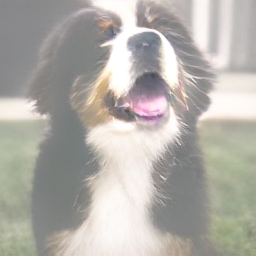

In [65]:
custom_to_pil(xrec[0])